<a href="https://colab.research.google.com/github/Kals-13/Memes-vs-Notes/blob/master/MvsN_w_o_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
path = "/content/gdrive/My Drive"

import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import random

In [87]:
p = os.path.join(path, "Memes")
images0 = []
for img in os.listdir(p):
  image = cv2.imread(os.path.join(p, img), cv2.IMREAD_UNCHANGED)
  image = cv2.resize(image, (100, 100))
  images0.append([image, 0])

In [88]:
images1 = []
p1 = os.path.join(path, "Notes")
for img in os.listdir(p1):
  image = cv2.imread(os.path.join(p1, img), cv2.IMREAD_UNCHANGED)
  image = cv2.resize(image, (100, 100))
  images1.append([image, 1])

In [94]:
test_set = images0[:48] + images1[:48]
validation_set = images0[48:80] + images1[48:80]
training_set = images0[80:] + images1[80:]

In [95]:
random.seed(10)

random.shuffle(training_set)
random.shuffle(test_set)
random.shuffle(validation_set)

1


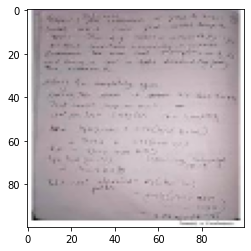

In [96]:
print(training_set[345][1])
plt.imshow(training_set[345][0])

In [97]:
training_set_X = []
training_set_Y = []
for features, label in training_set:
  training_set_X.append(features)
  training_set_Y.append(label)
training_set_X = np.array(training_set_X, dtype= np.int64)
m = training_set_X.shape[0]                                  
train_Y = np.reshape(np.array(training_set_Y), (1, m))

In [98]:
print(training_set_X.shape)
print(train_Y.shape)

(1440, 100, 100, 3)
(1, 1440)


In [99]:
n_x = training_set_X.shape[1]
train_X = np.reshape(training_set_X, (m, n_x * n_x * 3)).T
print(n_x)

100


In [100]:
print(train_X.shape)

(30000, 1440)


In [101]:
validation_X = []
validation_Y = []
for features, label in validation_set:
  validation_X.append(features)
  validation_Y.append(label)
validation_X = np.array(validation_X, dtype=np.int64)
validation_Y = np.reshape(np.array(validation_Y), (1, validation_X.shape[0]))
validation_X = np.reshape(validation_X, (validation_X.shape[0], validation_X.shape[1] * validation_X.shape[1] * 3)).T

In [102]:
print(validation_X.shape)
print(validation_Y.shape)

(30000, 64)
(1, 64)


In [103]:
test_X = []
test_Y = []
for features, label in test_set:
  test_X.append(features)
  test_Y.append(label)
test_X = np.array(test_X, dtype=np.int64)
test_Y = np.reshape(np.array(test_Y), (1, test_X.shape[0]))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1] * test_X.shape[1] * 3)).T

In [104]:
print(test_X.shape)
print(test_Y.shape)

(30000, 96)
(1, 96)


In [105]:
train_X = train_X/256
validation_X = validation_X/256
test_X = test_X/256

In [106]:
def initialise_parameters(layer_dims):
  L = len(layer_dims) - 1
  parameters= {}
  for l in range(L):
    parameters["W" + str(l+1)] = np.random.randn(layer_dims[l+1], layer_dims[l]) * np.sqrt(2/layer_dims[l])
    parameters["b" + str(l+1)] = np.zeros((layer_dims[l+1], 1))
  return parameters

In [107]:
def relu_activation(z):
  return np.maximum(z, 0)

In [108]:
def sigmoid_activation(z):
  return (1 / (1 + np.exp(-z)))

In [109]:
def create_minibatches(X, Y, seed, mini_batch_size = 40):
  np.random.seed(seed)

  mini_batches = []
  m = X.shape[1]
  minibatch_num = m // mini_batch_size

  permutations = list(np.random.permutation(m))
  X_shuffled = X[:, permutations]
  Y_shuffled = np.reshape(Y[:, permutations], (1, m))
  for i in range(0, minibatch_num):
    mini_batch_X = X_shuffled[:, i * mini_batch_size: (i+1) * mini_batch_size]
    mini_batch_Y = Y_shuffled[:, i * mini_batch_size: (i+1) * mini_batch_size]
    mini_batches.append((mini_batch_X, mini_batch_Y))

  return mini_batches

In [110]:
def forward_activation(A_prev, W, b, activation):
  Z = np.dot(W, A_prev) + b
  linear_cache = (A_prev, W, b)
  activation_cache = Z
  caches = (linear_cache, activation_cache)
  return (relu_activation(Z), caches) if activation == "relu" else (sigmoid_activation(Z), caches)

In [111]:
def forward_propagation(X, parameters):
  caches = []
  L = len(parameters) // 2
  A_prev = X 
  for l in range(1, L):
    A_prev, cache = forward_activation(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], "relu")
    caches.append(cache)  
  AL, cache = forward_activation(A_prev, parameters["W" + str(L)], parameters["b" + str(L)], "sigmoid")
  caches.append(cache)
  return AL, caches

In [112]:
def cost_function(Y, AL, l, parameters):
  n = Y.shape[1]
  L = len(parameters) // 2
  W_s = 0
  for i in range(L):
    W_s = W_s + np.sum(np.square(parameters["W" + str(i+1)]))
  try:
    cross_entropy_loss = (-1/n)* np.sum((1 - Y) * np.log(1 - AL) + Y * np.log(AL))
    cost = cross_entropy_loss + (1/n) * (l/2) * W_s
  except ZeroDivisionError:
    cost = (1/n) * (l/2) * W_s
  return np.squeeze(cost)

In [113]:
def linear_backward(A_prev, W, b, dZ, l):
  n = A_prev.shape[1]
  dA_prev = (1/n) * np.dot(W.T, dZ)
  dW = (1/n) * np.dot(dZ, A_prev.T) + (l * W /n)  
  db = (1/n) * np.sum(dZ, axis = 1, keepdims = True)
  return dA_prev, dW, db

In [114]:
def sigmoid_backward(dA, Z):
  A = 1/(1+np.exp(-Z))
  return dA * (1 - A) * A

In [115]:
def relu_backward(dA, Z):
  dZ = np.array(dA, copy = True)
  dZ[Z <= 0] = 0
  return dZ

In [116]:
def backward_propagation(AL, caches, Y, l):
  L = len(caches)
  grads = {}
  n = AL.shape[1]

  dAL = (-1) * (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
  linear_cache, activation_cache = caches[L-1]
  dZL = sigmoid_backward(dAL, activation_cache)
  current_cache = linear_backward(linear_cache[0], linear_cache[1], linear_cache[2], dZL, l)
  grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = current_cache[0], current_cache[1], current_cache[2]

  for l in reversed(range(L-1)):
    linear_cache, activation_cache = caches[l]
    dZ = relu_backward(current_cache[0], activation_cache)
    current_cache = linear_backward(linear_cache[0], linear_cache[1], linear_cache[2], dZ, l)
    grads["dA" + str(l)], grads["dW" + str(l+1)], grads["db" + str(l+1)] = current_cache[0], current_cache[1], current_cache[2]
  
  return grads

In [117]:
def initialise_adam(parameters):
  L = len(parameters) // 2
  v = {}
  s = {}
  for l in range(L):
    v["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape))
    v["db" + str(l+1)] = np.zeros((parameters["b" + str(l+1)].shape))
    s["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape))
    s["db" + str(l+1)] = np.zeros((parameters["b" + str(l+1)].shape))
  return v, s

In [118]:
def update_parameters(grads, parameters, learning_rate, v, s, t, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8):
  L = len(parameters) // 2
  v_updated = {}
  s_updated = {}
  for l in range(L):
    v["dW" + str(l+1)] = beta1 * v["dW" + str(l+1)] + (1-beta1) * grads["dW" + str(l+1)]
    v["db" + str(l+1)] = beta1 * v["db" + str(l+1)] + (1-beta1) * grads["db" + str(l+1)]
    v_updated["dW" + str(l+1)] = v["dW" + str(l+1)] / (1-pow(beta1, t))
    v_updated["db" + str(l+1)] = v["db" + str(l+1)] / (1-pow(beta1, t))
    
    s["dW" + str(l+1)] = beta2 * s["dW" + str(l+1)] + (1-beta2) * (grads["dW" + str(l+1)] ** 2)
    s["db" + str(l+1)] = beta2 * s["db" + str(l+1)] + (1-beta2) * (grads["db" + str(l+1)] ** 2)
    s_updated["dW" + str(l+1)] = s["dW" + str(l+1)] / (1-pow(beta2, t))
    s_updated["db" + str(l+1)] = s["db" + str(l+1)] / (1-pow(beta2, t))

    parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * v_updated["dW" + str(l+1)]/(np.sqrt(s_updated["dW" + str(l+1)] + epsilon))
    parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * v_updated["db" + str(l+1)]/(np.sqrt(s_updated["db" + str(l+1)] + epsilon))

  return parameters, v, s


In [119]:
def predict_labels(X, Y, parameters):
  m = Y.shape[1]
  Y_predicted = np.zeros((1, m))
  A, cache = forward_propagation(X, parameters)
  for i in range(m):
    if A[0][i] > 0.5:
      Y_predicted[0][i] = 1
  differences = np.mean(np.abs(Y_predicted - Y))
  accuracy = 100 - differences * 100
  return accuracy

In [120]:
def model(X, Y, layer_dims, learning_rate, num_epochs, l, parameters, v, s):
  random.seed(5)
  cost_total = 0
  costs = []
  m = X.shape[1]
  t = 0
  seed = 0
  for i in range(num_epochs):
    seed += 1
    cost_total = 0
    mini_batches = create_minibatches(X, Y, seed)
    for minibatch in mini_batches:
      mini_batch_X, mini_batch_Y = minibatch
      AL, caches = forward_propagation(mini_batch_X, parameters)
      cost_total += cost_function(mini_batch_Y, AL, l, parameters)
      grads = backward_propagation(AL, caches, mini_batch_Y, l)
      t += 1
      parameters, v, s = update_parameters(grads, parameters, learning_rate, v, s, t)
  
    avg_cost = cost_total / m
    print(avg_cost)
    costs.append(avg_cost)

  plt.plot(costs)
  plt.ylabel('cost')
  plt.xlabel('epochs')
  plt.show()
  return parameters, v, s

In [195]:
layer_dims =  [train_X.shape[0], 200, 100, 50, 1]
initial_parameters = initialise_parameters(layer_dims)
v, s = initialise_adam(initial_parameters)

0.1590207465803457
0.14057001125730684
0.12889073338999502
0.12111335645310634
0.1159573609157553
0.11247970421589788
0.11022985686325243
0.10868113364127209


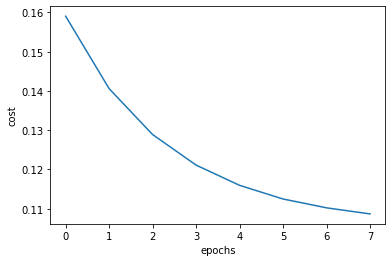

Training set accuracy 86.94444444444444


In [196]:
parameters1, v_train, s_train = model(train_X, train_Y, layer_dims, 0.0007, 8, 0.7, initial_parameters, v, s)
print("Training set accuracy", predict_labels(train_X, train_Y, parameters1))

0.06799567678790511
0.06791246457697815
0.06792336036054804
0.06792955170165102
0.06771122029861444
0.06782634327624842
0.06770679982673285
0.06799431679200167


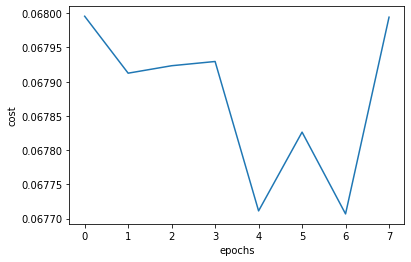

Validation set accuracy 73.4375


In [197]:
parameters2, v_valid, s_valid = model(validation_X, validation_Y, layer_dims, 0.0007, 8, 0.7, parameters1, v_train, s_train)
print("Validation set accuracy", predict_labels(validation_X, validation_Y, parameters2))

In [198]:
print("test set accuracy", predict_labels(test_X, test_Y, parameters1))

test set accuracy 93.75
